In [1]:
# ====== CELL 1: Basic setup (GPU check) ======
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cuda


In [2]:
!pip install kagglehub --quiet
!pip install torch torchvision torchaudio --quiet
!pip install scikit-learn --quiet


In [3]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("mrunalnshah/crd-chest-x-ray-images-with-lung-segmented-masks")
print("Dataset downloaded to:", path)


Using Colab cache for faster access to the 'crd-chest-x-ray-images-with-lung-segmented-masks' dataset.
Dataset downloaded to: /kaggle/input/crd-chest-x-ray-images-with-lung-segmented-masks


In [4]:
import os

for root, dirs, files in os.walk(path):
    level = root.replace(path, "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 2 * (level + 1)
    for f in files[:5]:
        print(f"{subindent}{f}")


crd-chest-x-ray-images-with-lung-segmented-masks/
  prepare_image_dataset.ipynb
  CXR_Selected-Image-Dataset_Log.csv
  README.pdf
  CXR_Combined/
    images/
      DARCXR_5944.png
      DARCXR_2224.png
      DARCXR_2783.png
      DARCXR_4908.png
      DARCXR_5024.png
    masks/
      DARCXR_5944.png
      DARCXR_2224.png
      DARCXR_2783.png
      DARCXR_4908.png
      DARCXR_5024.png
  CXR_RadioLucent_Mask/
    DARCXR_5944.png
    DARCXR_4908.png
    DARCXR_5024.png
    CHNCXR_413_1.png
    MCUCXR_75_0.png
  CXR_RadioLucent/
    DARCXR_5944.png
    DARCXR_4908.png
    DARCXR_5024.png
    CHNCXR_413_1.png
    MCUCXR_75_0.png
  CXR_RadioOpaque_Mask/
    DARCXR_2224.png
    DARCXR_2783.png
    DARCXR_6899.png
    DARCXR_3370.png
    DARCXR_3448.png
  CXR_RadioOpaque/
    DARCXR_2224.png
    DARCXR_2783.png
    DARCXR_6899.png
    DARCXR_3370.png
    DARCXR_3448.png


In [5]:
# EDIT THESE if needed based on the printed folder structure
IMAGES_DIR = path + "/CXR_png"      # Example path
MASKS_DIR  = path + "/masks"        # Example path

print("Images:", IMAGES_DIR)
print("Masks:", MASKS_DIR)


Images: /kaggle/input/crd-chest-x-ray-images-with-lung-segmented-masks/CXR_png
Masks: /kaggle/input/crd-chest-x-ray-images-with-lung-segmented-masks/masks


In [6]:
# ====== NEW CELL 4: Set paths for images and masks ======
import os, glob

# path is the root folder returned by kagglehub.dataset_download(...)
print("Root path:", path)

IMAGES_DIR = os.path.join(path, "CXR_Combined", "images")
MASKS_DIR  = os.path.join(path, "CXR_Combined", "masks")

print("Images dir:", IMAGES_DIR)
print("Masks  dir:", MASKS_DIR)

image_files = sorted(glob.glob(os.path.join(IMAGES_DIR, "*")))
mask_files  = sorted(glob.glob(os.path.join(MASKS_DIR, "*")))

print("Found", len(image_files), "image files")
print("Found", len(mask_files), "mask files")

if len(image_files) == 0 or len(mask_files) == 0:
    raise RuntimeError("Images or masks not found. Check IMAGES_DIR and MASKS_DIR.")


Root path: /kaggle/input/crd-chest-x-ray-images-with-lung-segmented-masks
Images dir: /kaggle/input/crd-chest-x-ray-images-with-lung-segmented-masks/CXR_Combined/images
Masks  dir: /kaggle/input/crd-chest-x-ray-images-with-lung-segmented-masks/CXR_Combined/masks
Found 3311 image files
Found 3311 mask files


In [7]:
# ====== NEW CELL 5: Build matching (image, mask) pairs ======
import os, glob

def get_stem(path_):
    return os.path.splitext(os.path.basename(path_))[0]

image_dict = {get_stem(p): p for p in glob.glob(os.path.join(IMAGES_DIR, "*"))}
mask_dict  = {get_stem(p): p for p in glob.glob(os.path.join(MASKS_DIR, "*"))}

common_keys = sorted(list(set(image_dict.keys()) & set(mask_dict.keys())))
print("Number of matching image–mask pairs:", len(common_keys))

pairs = [(image_dict[k], mask_dict[k]) for k in common_keys]

# Show a few samples
for p in pairs[:5]:
    print(p)


Number of matching image–mask pairs: 3311
('/kaggle/input/crd-chest-x-ray-images-with-lung-segmented-masks/CXR_Combined/images/CHNCXR_100_0.png', '/kaggle/input/crd-chest-x-ray-images-with-lung-segmented-masks/CXR_Combined/masks/CHNCXR_100_0.png')
('/kaggle/input/crd-chest-x-ray-images-with-lung-segmented-masks/CXR_Combined/images/CHNCXR_101_0.png', '/kaggle/input/crd-chest-x-ray-images-with-lung-segmented-masks/CXR_Combined/masks/CHNCXR_101_0.png')
('/kaggle/input/crd-chest-x-ray-images-with-lung-segmented-masks/CXR_Combined/images/CHNCXR_102_0.png', '/kaggle/input/crd-chest-x-ray-images-with-lung-segmented-masks/CXR_Combined/masks/CHNCXR_102_0.png')
('/kaggle/input/crd-chest-x-ray-images-with-lung-segmented-masks/CXR_Combined/images/CHNCXR_103_0.png', '/kaggle/input/crd-chest-x-ray-images-with-lung-segmented-masks/CXR_Combined/masks/CHNCXR_103_0.png')
('/kaggle/input/crd-chest-x-ray-images-with-lung-segmented-masks/CXR_Combined/images/CHNCXR_104_0.png', '/kaggle/input/crd-chest-x-ray

In [8]:
# ====== NEW CELL 6: Train/val/test split ======
from sklearn.model_selection import train_test_split

if len(pairs) == 0:
    raise RuntimeError("No image–mask pairs found. Check filename stems and folders.")

train_pairs, temp_pairs = train_test_split(pairs, test_size=0.3, random_state=42)
val_pairs, test_pairs   = train_test_split(temp_pairs, test_size=0.5, random_state=42)

print(f"Train: {len(train_pairs)}, Val: {len(val_pairs)}, Test: {len(test_pairs)}")


Train: 2317, Val: 497, Test: 497


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

IMG_SIZE = 256

class LungSegDataset(Dataset):
    def __init__(self, pairs, augment=False):
        self.pairs = pairs
        self.augment = augment

        self.img_tf = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

        self.mask_tf = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor()
        ])

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]

        img = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        img = self.img_tf(img)
        mask = self.mask_tf(mask)
        mask = (mask > 0.5).float()

        return img, mask

    def __len__(self):
        return len(self.pairs)

train_loader = DataLoader(LungSegDataset(train_pairs, True), batch_size=8, shuffle=True)
val_loader   = DataLoader(LungSegDataset(val_pairs), batch_size=8)
test_loader  = DataLoader(LungSegDataset(test_pairs), batch_size=8)

print("Loaders ready!")


Loaders ready!


In [10]:
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
        )
    def forward(self, x): return self.block(x)

class XNetUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = DoubleConv(1, 32)
        self.enc2 = DoubleConv(32, 64)
        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(64, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec2 = DoubleConv(128, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, 2, 2)
        self.dec1 = DoubleConv(64, 32)

        self.out = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))

        b = self.bottleneck(self.pool(x2))

        u2 = self.up2(b)
        d2 = self.dec2(torch.cat([u2, x2], 1))

        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, x1], 1))

        return self.out(d1)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = XNetUNet().to(device)
model


XNetUNet(
  (enc1): DoubleConv(
    (block): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (enc2): DoubleConv(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): DoubleConv(
    (block): Sequent

In [11]:
import torch.nn.functional as F
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    pred = pred.view(pred.size(0), -1)
    target = target.view(target.size(0), -1)
    intersection = (pred * target).sum(dim=1)
    union = pred.sum(dim=1) + target.sum(dim=1)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

def combined_loss(pred, target, alpha=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    d   = dice_loss(pred, target)
    return alpha * bce + (1 - alpha) * d

def dice_score(pred, target, threshold=0.5, smooth=1.0):
    pred_bin = (torch.sigmoid(pred) > threshold).float()
    pred_bin = pred_bin.view(pred_bin.size(0), -1)
    target   = target.view(target.size(0), -1)
    intersection = (pred_bin * target).sum(dim=1)
    union = pred_bin.sum(dim=1) + target.sum(dim=1)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice.mean().item()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
print("Ready to train on", device)


Ready to train on cuda


In [12]:
import time

def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    running_dice = 0.0

    for imgs, masks in loader:
        imgs  = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        running_dice += dice_score(outputs.detach(), masks.detach()) * imgs.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_dice = running_dice / len(loader.dataset)
    return epoch_loss, epoch_dice

def eval_model(model, loader):
    model.eval()
    running_loss = 0.0
    running_dice = 0.0

    with torch.no_grad():
        for imgs, masks in loader:
            imgs  = imgs.to(device)
            masks = masks.to(device)
            outputs = model(imgs)
            loss = combined_loss(outputs, masks)
            running_loss += loss.item() * imgs.size(0)
            running_dice += dice_score(outputs, masks) * imgs.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_dice = running_dice / len(loader.dataset)
    return epoch_loss, epoch_dice


In [13]:
num_epochs = 10  # you can increase later
best_val_dice = 0.0

for epoch in range(1, num_epochs + 1):
    start = time.time()
    train_loss, train_dice = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_dice = eval_model(model, val_loader)

    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), "best_xnet_unet.pth")

    elapsed = time.time() - start
    print(f"Epoch {epoch:02d}/{num_epochs} [{elapsed:.1f}s] "
          f"Train loss: {train_loss:.4f}, dice: {train_dice:.4f} | "
          f"Val loss: {val_loss:.4f}, dice: {val_dice:.4f}")

print("Best val dice:", best_val_dice)


Epoch 01/10 [103.9s] Train loss: 0.3728, dice: 0.8110 | Val loss: 0.2935, dice: 0.8769
Epoch 02/10 [73.3s] Train loss: 0.2440, dice: 0.8987 | Val loss: 0.2175, dice: 0.9095
Epoch 03/10 [74.4s] Train loss: 0.1874, dice: 0.9150 | Val loss: 0.1677, dice: 0.9180
Epoch 04/10 [73.6s] Train loss: 0.1516, dice: 0.9248 | Val loss: 0.1438, dice: 0.9222
Epoch 05/10 [73.7s] Train loss: 0.1308, dice: 0.9295 | Val loss: 0.1223, dice: 0.9338
Epoch 06/10 [73.4s] Train loss: 0.1165, dice: 0.9333 | Val loss: 0.1130, dice: 0.9348
Epoch 07/10 [73.5s] Train loss: 0.1068, dice: 0.9361 | Val loss: 0.1091, dice: 0.9328
Epoch 08/10 [73.9s] Train loss: 0.1018, dice: 0.9369 | Val loss: 0.1016, dice: 0.9364
Epoch 09/10 [73.6s] Train loss: 0.0951, dice: 0.9399 | Val loss: 0.0993, dice: 0.9360
Epoch 10/10 [73.7s] Train loss: 0.0919, dice: 0.9409 | Val loss: 0.0969, dice: 0.9369
Best val dice: 0.9368536870484381


In [14]:
# Load best weights (optional but recommended)
best_model = XNetUNet().to(device)
best_model.load_state_dict(torch.load("best_xnet_unet.pth", map_location=device))

test_loss, test_dice = eval_model(best_model, test_loader)
print(f"Test loss: {test_loss:.4f}, Test dice: {test_dice:.4f}")


Test loss: 0.0963, Test dice: 0.9370


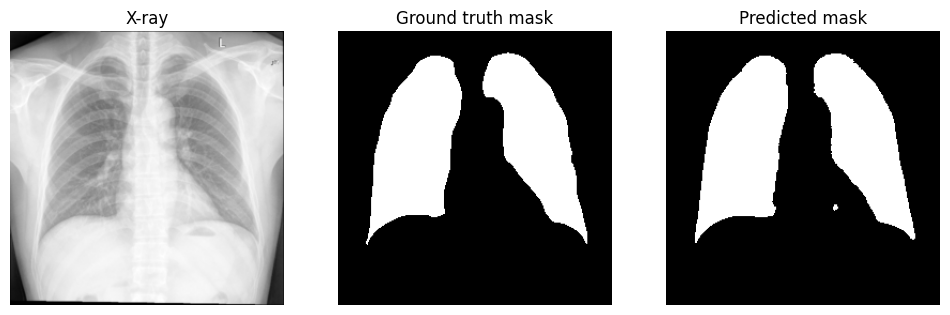

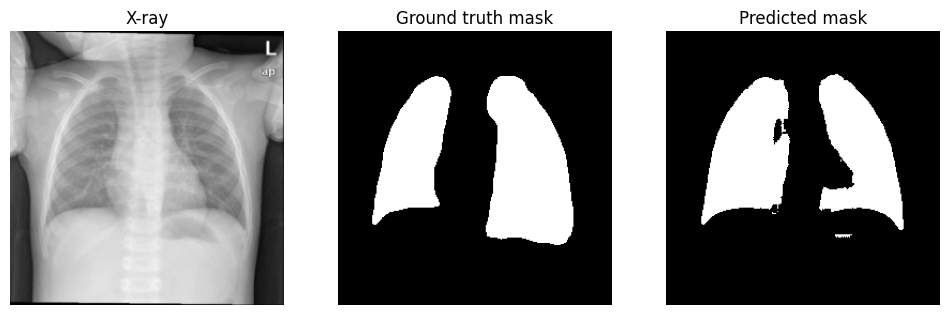

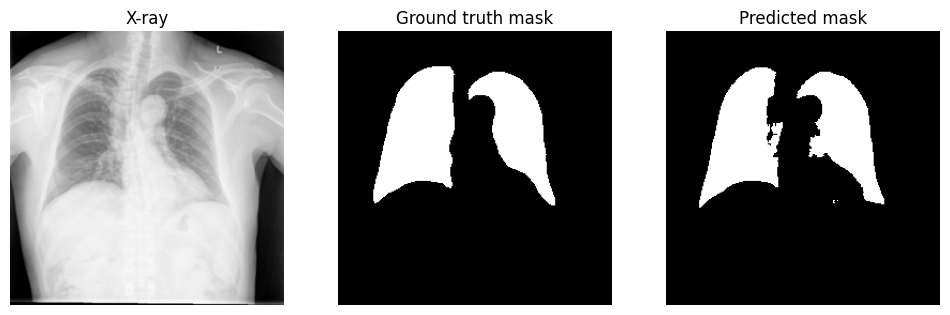

In [15]:
import matplotlib.pyplot as plt

best_model.eval()

with torch.no_grad():
    for imgs, masks in test_loader:
        imgs  = imgs.to(device)
        masks = masks.to(device)
        preds = torch.sigmoid(best_model(imgs))

        imgs_np  = imgs.cpu().numpy()
        masks_np = masks.cpu().numpy()
        preds_np = preds.cpu().numpy()

        for i in range(min(3, imgs_np.shape[0])):
            plt.figure(figsize=(12,4))
            plt.subplot(1,3,1)
            plt.imshow(imgs_np[i,0], cmap='gray')
            plt.title("X-ray"); plt.axis("off")

            plt.subplot(1,3,2)
            plt.imshow(masks_np[i,0], cmap='gray')
            plt.title("Ground truth mask"); plt.axis("off")

            plt.subplot(1,3,3)
            plt.imshow(preds_np[i,0] > 0.5, cmap='gray')
            plt.title("Predicted mask"); plt.axis("off")

            plt.show()
        break
